In [2]:
import torch
import sklearn
from sklearn.linear_model import LogisticRegression
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from scipy import sparse

import matplotlib.pyplot as plt
import numpy as np

from logger import set_logger
from copy import deepcopy

In [8]:
logger = set_logger("")
task_name = "arxiv"
checkpoint = torch.load(f"data/{task_name}.pt")
train_x, train_y, val_x, val_y, test_x, test_y = checkpoint["train_x"], checkpoint["train_y"], checkpoint["val_x"], checkpoint["val_y"],  checkpoint["test_x"], checkpoint["test_y"]
num_classes = checkpoint["num_classes"]

In [9]:
class Arxiv(Dataset):
    def __init__(self, sparse_x, y, transform=None):
        self.sparse_x = sparse_x
        self.y = torch.from_numpy(y)
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.sparse_x[idx].toarray()), self.y[idx]

In [10]:
batch_size = 256

In [11]:
trainset = Arxiv(train_x, train_y)
valset = Arxiv(val_x, val_y)
testset = Arxiv(test_x, test_y)

np.random.seed(0)
permutation = np.random.permutation(len(trainset))
calvalset = deepcopy(trainset)
trainset.y, trainset.sparse_x = trainset.y[permutation[:int(3.0 / 4 * len(trainset))]], trainset.sparse_x[permutation[:int(3.0 / 4 * len(trainset))]]
calvalset.y, calvalset.sparse_x = calvalset.y[permutation[int(3.0 / 4 * len(calvalset)):]], calvalset.sparse_x[permutation[int(3.0 / 4 * len(calvalset)):]]

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
calvalloader = torch.utils.data.DataLoader(calvalset, batch_size=batch_size, shuffle=False, num_workers=4)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

In [105]:
#study the distribution shift between train and test
p_full_train = np.bincount(trainset.y) / np.bincount(trainset.y).sum()
p_full_test = 0.5 * (np.bincount(testset.y) / np.bincount(testset.y).sum() + np.bincount(valset.y) / np.bincount(valset.y).sum())

In [12]:
device = "cuda"
model = "linear"
num_feat = train_x.shape[1]

In [13]:
def train(net, trainloader, optimizer, device, lam=0):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device).squeeze(), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        if lam > 0:
            for param in net.parameters():
                loss += lam * (param ** 2).sum()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    logger.info('==>>> train loss: {:.6f}, accuracy: {:.4f}'.format(train_loss/(batch_idx+1), 100.*correct/total))

def test(net, testloader, device):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device).squeeze(), targets.to(device)
            outputs = net(inputs)[:, :num_classes]
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        logger.info('==>>> test loss: {:.6f}, accuracy: {:.4f}'.format(test_loss/(batch_idx+1), 100.*correct/total))
    return 100.*correct/total

In [17]:
model = "linear"
epochs = 50
lam = 1e-6
net = torch.nn.Linear(num_feat, num_classes).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
for epoch in range(epochs):
    logger.info("epoch: {}".format(epoch))
    train(net, trainloader, optimizer, device, lam)
    acc = test(net, valloader, device)
    if epoch == int(epochs * 2 / 3):
        for g in optimizer.param_groups:
            g['lr'] *= 0.1
checkpoint = {"net": net.state_dict(), "acc": acc}
torch.save(checkpoint, "checkpoint/model/{}_{}_{}.pth".format(task_name, model, lam))

[22-04-12 03:22:58 root] epoch: 0
[22-04-12 03:22:58 root] epoch: 0
[22-04-12 03:23:06 root] ==>>> train loss: 2.855849, accuracy: 28.0132
[22-04-12 03:23:06 root] ==>>> train loss: 2.855849, accuracy: 28.0132
[22-04-12 03:23:12 root] ==>>> test loss: 2.629063, accuracy: 29.1134
[22-04-12 03:23:12 root] ==>>> test loss: 2.629063, accuracy: 29.1134
[22-04-12 03:23:12 root] epoch: 1
[22-04-12 03:23:12 root] epoch: 1
[22-04-12 03:23:21 root] ==>>> train loss: 2.454038, accuracy: 31.8202
[22-04-12 03:23:21 root] ==>>> train loss: 2.454038, accuracy: 31.8202
[22-04-12 03:23:26 root] ==>>> test loss: 2.336860, accuracy: 33.1468
[22-04-12 03:23:26 root] ==>>> test loss: 2.336860, accuracy: 33.1468
[22-04-12 03:23:26 root] epoch: 2
[22-04-12 03:23:26 root] epoch: 2
[22-04-12 03:23:35 root] ==>>> train loss: 2.184074, accuracy: 40.2863
[22-04-12 03:23:35 root] ==>>> train loss: 2.184074, accuracy: 40.2863
[22-04-12 03:23:40 root] ==>>> test loss: 2.116032, accuracy: 41.4960
[22-04-12 03:23:40 r

[22-04-12 03:28:32 root] ==>>> train loss: 0.952932, accuracy: 80.0685
[22-04-12 03:28:37 root] ==>>> test loss: 1.000593, accuracy: 72.8888
[22-04-12 03:28:37 root] ==>>> test loss: 1.000593, accuracy: 72.8888
[22-04-12 03:28:37 root] epoch: 24
[22-04-12 03:28:37 root] epoch: 24
[22-04-12 03:28:46 root] ==>>> train loss: 0.942320, accuracy: 80.3160
[22-04-12 03:28:46 root] ==>>> train loss: 0.942320, accuracy: 80.3160
[22-04-12 03:28:52 root] ==>>> test loss: 0.990528, accuracy: 73.0000
[22-04-12 03:28:52 root] ==>>> test loss: 0.990528, accuracy: 73.0000
[22-04-12 03:28:52 root] epoch: 25
[22-04-12 03:28:52 root] epoch: 25
[22-04-12 03:29:00 root] ==>>> train loss: 0.932649, accuracy: 80.4997
[22-04-12 03:29:00 root] ==>>> train loss: 0.932649, accuracy: 80.4997
[22-04-12 03:29:06 root] ==>>> test loss: 0.982325, accuracy: 73.0513
[22-04-12 03:29:06 root] ==>>> test loss: 0.982325, accuracy: 73.0513
[22-04-12 03:29:06 root] epoch: 26
[22-04-12 03:29:06 root] epoch: 26
[22-04-12 03:29

[22-04-12 03:34:03 root] ==>>> test loss: 0.931998, accuracy: 73.3029
[22-04-12 03:34:03 root] epoch: 47
[22-04-12 03:34:03 root] epoch: 47
[22-04-12 03:34:11 root] ==>>> train loss: 0.863168, accuracy: 82.2018
[22-04-12 03:34:11 root] ==>>> train loss: 0.863168, accuracy: 82.2018
[22-04-12 03:34:17 root] ==>>> test loss: 0.931660, accuracy: 73.3097
[22-04-12 03:34:17 root] ==>>> test loss: 0.931660, accuracy: 73.3097
[22-04-12 03:34:17 root] epoch: 48
[22-04-12 03:34:17 root] epoch: 48
[22-04-12 03:34:25 root] ==>>> train loss: 0.862645, accuracy: 82.2246
[22-04-12 03:34:25 root] ==>>> train loss: 0.862645, accuracy: 82.2246
[22-04-12 03:34:31 root] ==>>> test loss: 0.931315, accuracy: 73.3183
[22-04-12 03:34:31 root] ==>>> test loss: 0.931315, accuracy: 73.3183
[22-04-12 03:34:31 root] epoch: 49
[22-04-12 03:34:31 root] epoch: 49
[22-04-12 03:34:39 root] ==>>> train loss: 0.862338, accuracy: 82.2429
[22-04-12 03:34:39 root] ==>>> train loss: 0.862338, accuracy: 82.2429
[22-04-12 03:3

In [18]:
def get_logits(dataloader, net, num_classes, device):
    net.eval()
    correct = 0
    test_loss = 0
    total = 0
    logits = torch.zeros(len(dataloader.dataset), num_classes)
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs).squeeze()
            
            logits[(batch_idx * batch_size):((batch_idx + 1) * batch_size)] = outputs
            
            loss = criterion(outputs, targets)
            
            _, predicted = outputs.max(1)
            
            test_loss += loss.item()
            total += targets.size(0)
            
            correct += predicted.eq(targets).sum().item()
        logger.info('==>>> test loss: {:.6f}, accuracy: {:.4f}'.format(test_loss/(batch_idx+1), 100.*correct/total))
    
    return logits

def get_conf_mat(logits, labels, num_classes):
    conf_mat = torch.zeros(num_classes, num_classes)
    for pred, label in tqdm(zip(logits.max(1)[1], labels)):
        conf_mat[label, pred] += 1
    conf_mat = (conf_mat.t() / conf_mat.sum(1)).t()
    return conf_mat
    

In [19]:
net = torch.nn.Linear(num_feat, num_classes).to(device)
checkpoint = torch.load("checkpoint/model/{}_{}_{}.pth".format(task_name, model, lam))
net.load_state_dict(checkpoint["net"])
criterion = torch.nn.CrossEntropyLoss()

In [20]:
val_logits = get_logits(valloader, net, num_classes, device)
val_conf_mat = get_conf_mat(val_logits, valset.y, num_classes)

test_logits = get_logits(testloader, net, num_classes, device)
test_conf_mat = get_conf_mat(test_logits, testset.y, num_classes)

calval_logits = get_logits(calvalloader, net, num_classes, device)

[22-04-12 03:35:30 root] ==>>> test loss: 0.930982, accuracy: 73.3149
[22-04-12 03:35:30 root] ==>>> test loss: 0.930982, accuracy: 73.3149
58437it [00:01, 45787.52it/s]
[22-04-12 03:35:37 root] ==>>> test loss: 0.973362, accuracy: 72.4216
[22-04-12 03:35:37 root] ==>>> test loss: 0.973362, accuracy: 72.4216
58437it [00:01, 48019.69it/s]
[22-04-12 03:35:42 root] ==>>> test loss: 0.899961, accuracy: 74.0511
[22-04-12 03:35:42 root] ==>>> test loss: 0.899961, accuracy: 74.0511


In [21]:
p_train = np.bincount(trainset.y) / np.bincount(trainset.y).sum()
p_val = np.bincount(valset.y) / np.bincount(valset.y).sum()
p_true_test = np.bincount(testset.y) / np.bincount(testset.y).sum()
p_est_test = (p_true_test.dot(test_conf_mat.numpy())).dot(np.linalg.inv(val_conf_mat.numpy()))

In [22]:
for p_test in [p_true_test, p_est_test, p_train, p_val]:
    test_probs_adjust = nn.Softmax()(test_logits) * p_test / p_train
    pred_adjust = test_probs_adjust.max(1)[1]
    print(pred_adjust.eq(testset.y).float().mean())

/home/rw565/.conda/envs/dfiattack2/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


tensor(0.7248)
tensor(0.7234)
tensor(0.7242)
tensor(0.7292)


In [23]:
# cal_num = len(val_logits) // 2
def T_scaling(logits, temperature):
    return torch.div(logits, temperature)

temperature = nn.Parameter(torch.ones(1).cuda())
criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS([temperature], lr=0.001, max_iter=10000, line_search_fn='strong_wolfe')

def _eval():
    loss = criterion(T_scaling(calval_logits.to(device), temperature.to(device)), calvalset.y.to(device))
    loss.backward()
    return loss

for i in range(100):
    optimizer.zero_grad()
    optimizer.step(_eval)

In [24]:
print(temperature)

Parameter containing:
tensor([0.7041], device='cuda:0', requires_grad=True)


In [26]:
for p_test in [p_true_test, p_est_test, p_train, p_val]:
    cal_test_logits = T_scaling(test_logits, temperature.cpu()).detach()
    test_probs_adjust = nn.Softmax()(cal_test_logits) * p_test / p_train
    pred_adjust = test_probs_adjust.max(1)[1]
#     print(p_test/p_train)
    print(pred_adjust.eq(testset.y).float().mean())

tensor(0.7356)
tensor(0.7356)
tensor(0.7242)
tensor(0.7340)


/home/rw565/.conda/envs/dfiattack2/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
checkpoint = {}
checkpoint["val_preds"] = T_scaling(val_logits, temperature.cpu()).detach().numpy()
checkpoint["val_y"] = valset.y
checkpoint["conf_mat"] = val_conf_mat
torch.save(checkpoint, "val_arxiv_{}_cal.pt".format(model))
checkpoint = {}
checkpoint["test_preds"] = T_scaling(test_logits, temperature.cpu()).detach().numpy()
checkpoint["y"] = testset.y
checkpoint["p_train"] = p_train
torch.save(checkpoint, "test_arxiv_{}_cal.pt".format( model))

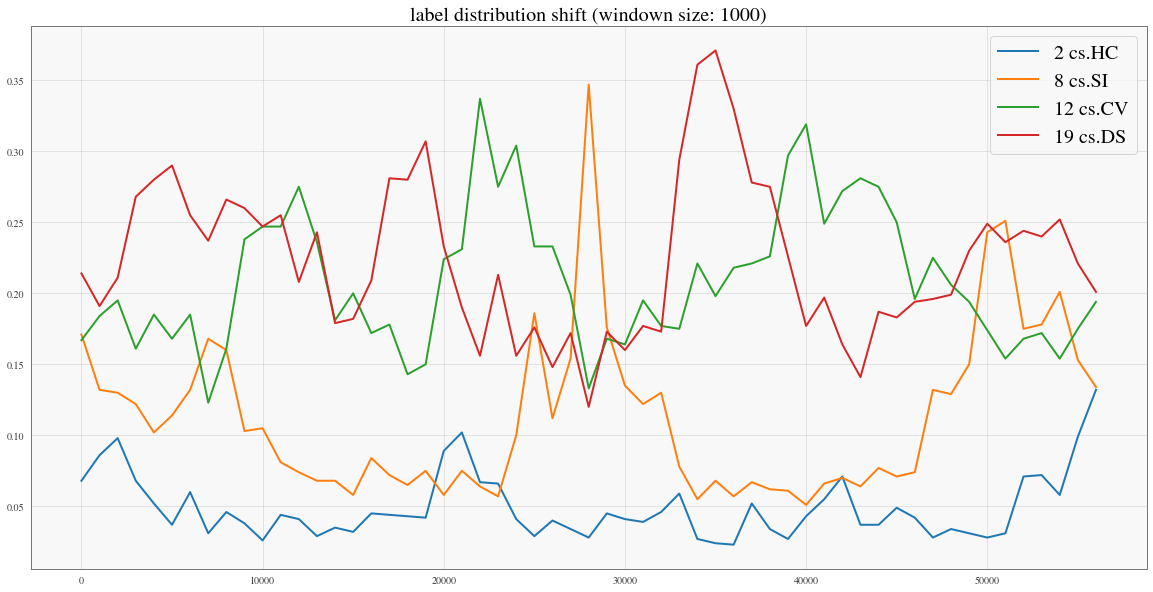

In [31]:
#show how label shift during the test
raw_checkpoint = torch.load("data/arxiv_raw_cs_more_wcco_30.pt") #_new_new_val
abstracts_bow = raw_checkpoint["abstracts_bow"]
categories_label = np.asarray(raw_checkpoint["categories_label"])
categories_dict = raw_checkpoint["categories_dict"]
del raw_checkpoint
remain_classes = []
num_classes = 40
remain_category_label = []
for i in range(num_classes):
    if (np.asarray(categories_label) == i).sum() >= 3000:
        remain_classes.append(i)
        remain_category_label.append(list(categories_dict.keys())[i])
    
num_classes = 23
for window_size in [1000]:
    fontsize = 20
    plt.figure(figsize=(20,10))
    label_list = [str(i) + " " + remain_category_label[i] for i in range(num_classes)] #['2014', '2015', '2016', '2017']
    x = np.arange(int(len(testset.y) / window_size)-1) * window_size

    for i in range(num_classes):
        if (testset.y.numpy() == i).mean() < 0.05:
            continue
        label_dist = [(testset.y.numpy()[window_ind * window_size : (window_ind + 1) * window_size] == i).mean() for window_ind in range(len(x))]
        plt.plot(x, label_dist, label=label_list[i])
    plt.title("label distribution shift (windown size: {})".format(window_size), fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.show()